In [599]:
import numpy as np
import pandas as pd
import math
import sys, os
#import seaborn as sns
#from scipy import stats
#from pathlib import Path
#import matplotlib.pyplot as plt
#from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.datasets import fetch_california_housing
#import math
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from optuna.samplers import TPESampler
#import lightgbm as lgbm
#from xgboost import XGBRegressor
import xgboost as xgb
#from catboost import CatBoostRegressor
#from lightgbm.sklearn import LGBMRegressor
#from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.max_columns', 500)
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn import metrics

import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import math
import pickle
import mplcyberpunk
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping
plt.style.use("cyberpunk")

In [14]:
from itertools import islice, cycle

plt.style.use("cyberpunk")

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [15]:
train_time = 1 * 60 * 60
objective = 'tfregressor'

In [16]:
sys.path.append(os.path.realpath('..'))

In [407]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [408]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Age,0,0.0
StockOptionLevel,0,0.0
Over18,0,0.0
OverTime,0,0.0
PercentSalaryHike,0,0.0
PerformanceRating,0,0.0
RelationshipSatisfaction,0,0.0
StandardHours,0,0.0
TotalWorkingYears,0,0.0
BusinessTravel,0,0.0


In [409]:
del train_df['Over18']
del train_df['EmployeeCount']
del train_df['StandardHours']

In [410]:
columns_to_vectorize = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
for vector_target in columns_to_vectorize:
    print(vector_target)
    vectorizer = CountVectorizer()
    vectorizer.fit_transform(train_df[vector_target])
    train_df[f'{vector_target}_v'] = vectorizer.transform(train_df[vector_target]).toarray().argmax(axis=1)[:,None]
    vectorizer.fit_transform(test_df[vector_target])
    test_df[f'{vector_target}_v'] = vectorizer.transform(test_df[vector_target]).toarray().argmax(axis=1)[:,None]

BusinessTravel
Department
EducationField
Gender
JobRole
MaritalStatus
OverTime


In [644]:
orig_features = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime' ]

cat_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

features = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'BusinessTravel_v', 'Department_v', 'EducationField_v','Gender_v', 'JobRole_v', 'MaritalStatus_v', 'OverTime_v']

features_v2 = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'BusinessTravel_v', 'Department_v', 'EducationField_v', 'JobRole_v', 'MaritalStatus_v']


target = ['Attrition']
split_targets= ['Attrition_0', 'Attrition_1']

In [645]:
#features= features_v2

In [646]:
train_df['Attrition_0'] = 0
train_df['Attrition_1'] = 0

train_df.loc[train_df['Attrition']==0, 'Attrition_0'] = 1
train_df.loc[train_df['Attrition']==1, 'Attrition_1'] = 1

In [647]:
scaler = StandardScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[split_targets])
Y = scaler.transform(train_df[split_targets])

In [648]:
RANDOM_STATE = 12 
FOLDS = 5
param_grid_history = {}

import tensorflow as tf
from sklearn.metrics import roc_auc_score

def objective_v3(trial):
    oof = np.zeros(len(X))
    scores = []
   
        
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
        print(10*"=", f"Fold={fold+1}", 10*"=")
        X_train, X_valid = train_df.iloc[train_idx][features], train_df.iloc[valid_idx][features]
        y_train , y_valid = train_df[target].iloc[train_idx] , train_df[target].iloc[valid_idx] 
        
        X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.20)

        model = tf.keras.Sequential([
            layers.Dense(1000, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(1000, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ])

        #reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        model.compile(
            loss='binary_crossentropy', optimizer='adam',metrics=['accuracy']
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),

            epochs=10,
            # Suppress logging.
            verbose=1,
        )
           
        oof[valid_idx] = model.predict(X_valid)[0]

    roc_auc = roc_auc_score(Y, oof)
    
    param_grid_history[roc_auc] = {}

    return roc_auc

In [649]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name=objective)
study.optimize(objective_v3, timeout=train_time)

[I 2023-01-22 20:22:52,924] A new study created in memory with name: tfregressor
[W 2023-01-22 20:22:52,926] Trial 0 failed because of the following error: ValueError("Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.")
Traceback (most recent call last):
  File "D:\source\repos\venv\Python310\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ryans\AppData\Local\Temp\ipykernel_12384\4162313688.py", line 14, in objective_v3
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
  File "D:\source\repos\venv\Python310\lib\site-packages\sklearn\model_selection\_split.py", line 352, in split
    for train, test in super().split(X, y, groups):
  File "D:\source\repos\venv\Python310\lib\site-packages\sklearn\model_selection\_split.py", line 85, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "D:\source\repos\venv\Python310\lib\site-packages\skle

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [651]:
max_features = 5000  # Maximum vocab size.
max_len = 4  # Sequence length to pad the outputs to.

X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.60)

model = tf.keras.Sequential([

    layers.Dense(1, activation="sigmoid"),
])

#reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
#model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC(name='auc')])


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),

    epochs=100,
    # Suppress logging.
    verbose=1,
)

full_prediction = model.predict(train_df[features])

Epoch 1/100
21/21 [==============================] - 1s 14ms/step - loss: 3801.2451 - auc: 0.5000 - val_loss: 3355.5168 - val_auc: 0.5000
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 3381.1443 - auc: 0.5000 - val_loss: 2954.7441 - val_auc: 0.5000
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 2962.3530 - auc: 0.5000 - val_loss: 2552.9041 - val_auc: 0.5000
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 2541.8325 - auc: 0.5000 - val_loss: 2151.1821 - val_auc: 0.5000
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 2120.8494 - auc: 0.5000 - val_loss: 1751.1460 - val_auc: 0.5000
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 1702.2295 - auc: 0.5000 - val_loss: 1347.5693 - val_auc: 0.5000
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 1283.1812 - auc: 0.4802 - val_loss: 952.0010 - val_auc: 0.4659
Epoch 8/100
21/21 [======================

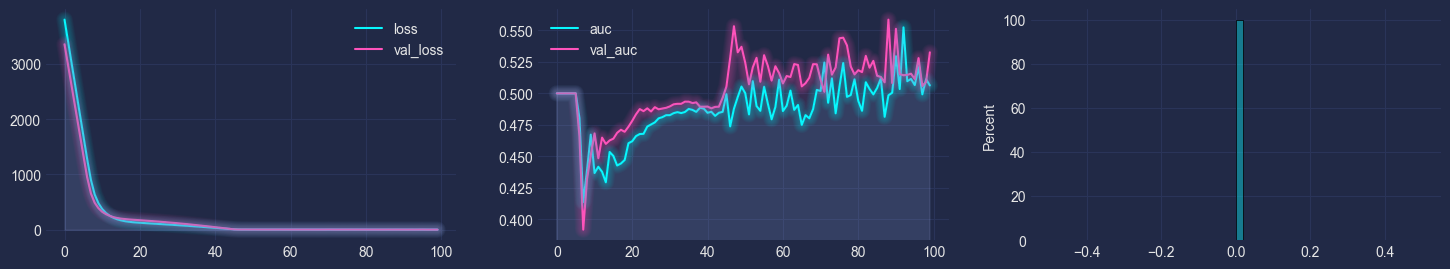

In [652]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

n_cols = 3
n_rows = 1
cell_with_dim = 6
cell_height_dim = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

sns.lineplot(history.history['loss'], label='loss', ax=ax[0])
sns.lineplot(history.history['val_loss'], label='val_loss', ax=ax[0])

mplcyberpunk.make_lines_glow(ax[0])
mplcyberpunk.add_underglow(ax[0])

sns.lineplot(history.history['auc'], label='auc', ax=ax[1])
sns.lineplot(history.history['val_auc'], label='val_auc', ax=ax[1])

mplcyberpunk.make_lines_glow(ax[1])
mplcyberpunk.add_underglow(ax[1])

sns.histplot(full_prediction.argmax(1), ax=ax[2], **histplot_hyperparams, color='#08F7FE')

mplcyberpunk.make_lines_glow(ax[2])




plt.show()

In [653]:
full_prediction

array([[3.7884028e-04],
       [8.3750981e-01],
       [6.7289802e-04],
       ...,
       [9.9999797e-01],
       [3.0232099e-04],
       [9.9905246e-01]], dtype=float32)

In [654]:
preds = model.predict(train_df[features])

53/53 [==============================] - 0s 673us/step


In [655]:
roc_auc_score(train_df[split_targets], preds)

0.44677217332430597

In [656]:
np.unique(preds.argmax(1), return_counts=True)

(array([0], dtype=int64), array([1677], dtype=int64))

In [657]:
roc_auc_score(train_df[target], preds.argmax(1))

0.5

In [658]:
train_df[target][3:6]

,Attrition
id,
3,0
4,1
5,0


In [626]:
preds.argmax(1)[3:6]

array([0, 0, 0], dtype=int64)

In [555]:
train_preds = []
train_preds.append(model.predict(train_df[features]).argmax(1))
train_final_preds = np.stack(train_preds).mean(0)

train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds.reshape(len(train_final_preds)).tolist()})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

53/53 [==============================] - 0s 719us/step


In [335]:
test_preds = []
test_preds.append(model.predict(test_df[features]).argmax(1))
test_final_preds = np.stack(test_preds).mean(0)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds.reshape(len(test_final_preds)).tolist()})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

35/35 [==============================] - 0s 765us/step


In [ ]:
parm_grid_bytes = pickle.dumps(param_grid_history)
with open(f"rendered_data/{objective}_bytes.hex", "wb") as binary_file:
    binary_file.write(parm_grid_bytes)

In [ ]:
def train(param_grid):
    reg = xgb.XGBModel(
        # These parameters should help with trial speed.
        objective='binary:logistic',
        tree_method='gpu_hist',
        booster='gbtree',
        predictor='gpu_predictor',
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        **param_grid
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.20)
    
    reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        
    return reg

percent = math.ceil(len(param_grid_history.keys()) * .1)
top = sorted(list(param_grid_history.keys()))[-percent:]

train_preds = []
test_preds = []
for key in tqdm(top):
    model = train(param_grid_history[key])
    train_preds.append(model.predict(train_df[features]))
    test_preds.append(model.predict(test_df[features]))

train_final_preds = np.stack(train_preds).mean(0)
test_final_preds = np.stack(test_preds).mean(0)

In [ ]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)